In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os

sys.path.insert(0, "/home/aew492/research-summer2020/code")
from suave import cf_model, cosmo_bases
import recover_amps
import generate_mock_list
import globals
globals.initialize_vals()
cat_tag = globals.cat_tag

In [2]:
bias = 2.0
# import 'true' cf
r_t, cf_t = np.loadtxt("/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_Rh_xi.txt", unpack=True)
cf_t_2 = cf_t * bias**2

In [3]:
# make sure current global values match 'true' cf
print(globals.boxsize, globals.lognormal_density, globals.As, globals.n_mocks, globals.mock_type)

750 1e-4 2 401 1m


### get basis functions

In [4]:
# base_vals: redshift 0.57, bias 2.0
projfn = 'cosmo_basis.dat'

bases = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.57, bias=2.0)
ncomponents = 4*(bases.shape[1]-1)
r_base = bases[:,0]
base_vals = bases[:,1]
base_vals.shape
base_vals[0]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


0.2094052219144891

In [5]:
# base_vals_0: redshift 0.0, bias 1.0
bases_0 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.0, bias=1.0)
ncomponents = 4*(bases.shape[1]-1)
r_base = bases_0[:,0]
base_vals_0 = bases_0[:,1]
base_vals_0.shape
base_vals_0[0]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


0.09453997058328575

In [6]:
# base_vals_2: redshift 0.0, bias 2.0
bases_2 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.0, bias=2.0)
ncomponents = 4*(bases.shape[1]-1)
r_base = bases_2[:,0]
base_vals_2 = bases_2[:,1]
base_vals_2.shape
base_vals_2[0]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


0.378159882333143

In [7]:
# base_vals_2: redshift 0.57, bias 1.0
bases_3 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.57, bias=1.0)
ncomponents = 4*(bases.shape[1]-1)
r_base = bases_3[:,0]
base_vals_3 = bases_3[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


### function: mean xi in each bin + error regions

In [8]:
def get_cfarr_vals(cf_arr):
    arr_len = len(cf_arr[0])
    cfs_mean = []
    stds = []
    error_regions = np.empty((arr_len, 2))
    for i in range(arr_len):
        mean, std = np.mean(cf_arr[:,i]), np.std(cf_arr[:,i])
        cfs_mean.append(mean)
        stds.append(std)
        error_regions[i] = [mean-std, mean+std]
    return cfs_mean, stds, error_regions

### recover amps

In [9]:
# double amplitudes
mock_file_name_list = generate_mock_list.generate_mock_list(As=2)
amps_suave = recover_amps.recover_amps(mock_file_name_list, cat_tag, basis='bao_fixed', method="suave")
# amps_patches, xi_patches = recover_amps.recover_amps(mock_file_name_list, cat_tag, method="patches", n_patches=8)
a_0s_s = amps_suave[:,0]

### suave

In [10]:
cf_arr_s = np.empty((len(a_0s_s), len(base_vals)))
for i in range(len(a_0s_s)):
    cf_arr_s[i] = a_0s_s[i] * base_vals
        
cfs_mean_s, _, error_regions_s = get_cfarr_vals(cf_arr_s)

### patches

In [11]:
r_edges = np.linspace(globals.rmin, globals.rmax, globals.nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])

xi_patches = np.array(xi_patches)

cfs_mean_p, stds_p, _ = get_cfarr_vals(xi_patches)

NameError: name 'xi_patches' is not defined

### clustered mocks, NO gradient

In [12]:
# results for clustered mocks, NO gradient, single amplitudes
mock_vals = generate_mock_list.generate_mock_list(As=1, extra=True)
mock_file_list = mock_vals['lognorm_file_list']
xi_arr_nograd = np.empty((len(mock_file_list), globals.nbins)) 
for i in range(len(mock_file_list)):
    r_avg, xi = np.load(f'/scratch/aew492/research-summer2020_output/lognormal/xi/ls/{cat_tag}/xi_{mock_file_list[i]}.npy')
    xi_arr_nograd[i] = xi

cfs_mean_nograd, stds_nograd, _ = get_cfarr_vals(xi_arr_nograd)

mock_vals_2x = generate_mock_list.generate_mock_list(As=2, extra=True)
mock_file_list_2x = mock_vals_2x['lognorm_file_list']
xi_arr_nograd_2x = np.empty((len(mock_file_list_2x), globals.nbins)) 
for i in range(len(mock_file_list_2x)):
    r_avg, xi = np.load(f'/scratch/aew492/research-summer2020_output/lognormal/xi/ls/{cat_tag}/xi_{mock_file_list_2x[i]}.npy')
    xi_arr_nograd_2x[i] = xi

cfs_mean_nograd_2x, stds_nograd_2x, _ = get_cfarr_vals(xi_arr_nograd_2x)

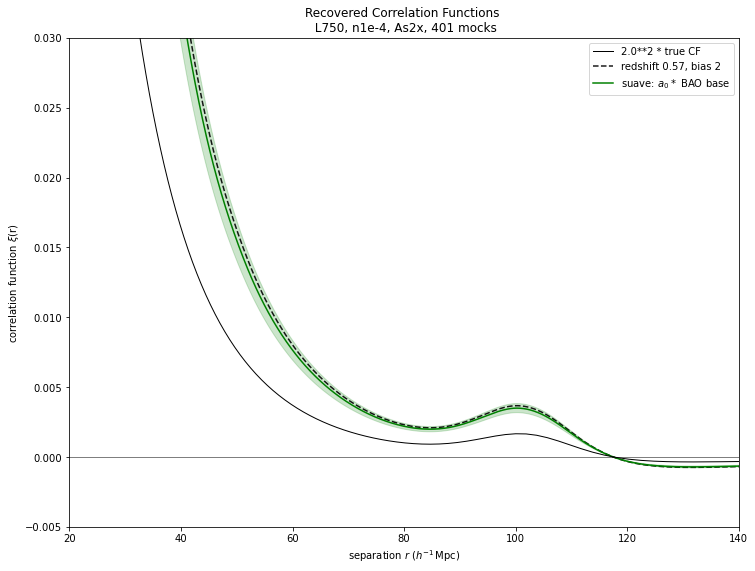

In [13]:
fig, ax = plt.subplots(figsize=(12,9))

ax.plot(r_t, cf_t, color='k', label='2.0**2 * true CF', ls='-', lw=1, zorder=1000)

ax.plot(r_base, base_vals, color='k', alpha=0.9, ls='--', label='redshift 0.57, bias 2')
#ax.plot(r_base, base_vals_0, color='k', alpha=0.6, ls='--', label='redshift 0, bias 1')
#ax.plot(r_base, base_vals_2, color='k', alpha=0.3, ls='--', label="redshift 0, bias 2")

ax.plot(r_base, cfs_mean_s, color='g', label=f'suave: $a_0 * $ BAO base')
ax.fill_between(r_base, error_regions_s[:,0], error_regions_s[:,1], color='green', alpha=0.2)

# ax.errorbar(r_avg, cfs_mean_p, yerr=stds_p, color='b', alpha=0.8, fmt='o', capsize=3, label=f'patches: recovered xi')

#ax.errorbar(r_avg, cfs_mean_nograd, yerr=stds_nograd, color='r', alpha=0.6, fmt='o', capsize=3, label=f'no grad: recovered xi')
#ax.errorbar(r_avg, cfs_mean_nograd_2x, yerr=stds_nograd_2x, color='orange', alpha=0.6, fmt='o', capsize=3, label=f'no grad: recovered xi 2x')

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Recovered Correlation Functions \n L{globals.boxsize}, n{globals.lognormal_density}, As{globals.As}x, {globals.n_mocks} mocks')
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.plot(r_t, cf_t, color='k', label='true CF', ls='-', lw=1, zorder=1000)
ax.plot(r_t, 4*cf_t, color='g', label='4*true CF', ls='-', lw=1, zorder=1000)

ax.plot(r_base, base_vals, color='k', alpha=0.9, ls='--', label='redshift 0.57, bias 2')
ax.plot(r_base, base_vals_0, color='k', alpha=0.6, ls='--', label='redshift 0, bias 1')
ax.plot(r_base, base_vals_2, color='k', alpha=0.3, ls='--', label="redshift 0, bias 2")
ax.plot(r_base, base_vals_3, color='b', alpha=0.3, ls='--', label="redshift 0.57, bias 1")

#ax.errorbar(r_avg, cfs_mean_nograd, yerr=stds_nograd, color='r', alpha=0.6, fmt='o', capsize=3, label=f'no grad: recovered xi')
#ax.errorbar(r_avg, cfs_mean_nograd_2x, yerr=stds_nograd_2x, color='orange', alpha=0.6, fmt='o', capsize=3, label=f'no grad: recovered xi 2x')

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Recovered Correlation Functions \n L{globals.boxsize}, n{num_den}, As{globals.As}x, {globals.n_mocks} mocks')
plt.legend()